# World Cup Hypothesis Testing - Fairness

In this experimemnt I will review cleaned data from the 2018 FIFA World Cup match-ups to determine the null hypothesis that the organization and bucketing of countries is statistically fair. 

Main concepts covered here are:
>
1. Hypothesis Workflow 
2. Hypothesis Creation 
3. Null Hypothesis Testing 
5. Multiple Hypothesis Testing
4. Probability Statistics
5. Data Science Visualizations 

This exercise is organized into 4 sections:
1. Data Processing
2. Data Summary
3. Investigative Visualization
4. Hypothesis Testing

Context: There are 32 teams, each representing a single country, that compete in groups or pools then the best teams from those groups compete in a single elimination tournament to see who will become world champions.

## 1. Data Processing

Standard Imports

In [2]:
import os
import pandas as pd
import re

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
%pip install statsmodels
import numpy as np
from scipy import stats
from statsmodels.stats.multicomp import MultiComparison

   ---------------------------------------- 0.0/10.0 MB ? eta -:--:--
   ----------- ---------------------------- 2.9/10.0 MB 15.2 MB/s eta 0:00:01
   ------------------------------ --------- 7.6/10.0 MB 19.6 MB/s eta 0:00:01
   ---------------------------------------- 10.0/10.0 MB 18.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Pull in the data to a dataframe

Save file to the same folder as the dataset and supporting material as the saved path of this file will be used for importing via the os.getcwd function.  

In [7]:
DATA_DIR = os.getcwd()
df = pd.read_csv(os.path.join(DATA_DIR, 'worldcup-2018.csv'))
df.columns = [re.sub("\s+","_",col.lower()) for col in df.columns]
df.head()

,team,group,previous_appearances,previous_titles,previous_finals,previous_semifinals,current_fifa_rank,first_match_against,match_index,history_with_first_opponent_w-l,history_with_first_opponent_goals,second_match_against,match_index.1,history_with_second_opponent_w-l,history_with_second_opponent_goals,third_match_against,match_index.2,history_with_third_opponent_w-l,history_with_third_opponent_goals,unnamed:_19
0,Russia,A,10,0,0,1,65,Saudi Arabia,1,-1.0,-2.0,Egypt,17,NaN,NaN,Uruguay,33,0.0,0.0,NaN
1,Saudi Arabia,A,4,0,0,0,63,Russia,1,1.0,2.0,Uruguay,18,1.0,1.0,Egypt,34,-5.0,-5.0,NaN
2,Egypt,A,2,0,0,0,31,Uruguay,2,-1.0,-2.0,Russia,17,NaN,NaN,Saudi Arabia,34,5.0,5.0,NaN
3,Uruguay,A,12,2,2,5,21,Egypt,2,1.0,2.0,Saudi Arabia,18,-1.0,-1.0,Russia,33,0.0,0.0,NaN
4,Porugal,B,6,0,0,2,3,Spain,3,-12.0,-31.0,Morocco,19,-1.0,-2.0,Iran,35,2.0,5.0,NaN


Narrow to the most important columns and use this as the base df. 

In [13]:
columns = ['team', 'group','previous_appearances','previous_titles','previous_finals',
           'previous_semifinals','current_fifa_rank']

df = df[columns]

df.shape

(32, 7)

To help with this analysis lets engineer a feature that combines all of the data in the table. This feature will represents the past performance of a team. Given the data we have it is a proxy for how good a team will perform. Here the multipliers can be changed but let’s just say that past_performance will be a linear combination of the related features we have.

Then let the corresponding vector α be the multipliers and create a calculation to evaluate past_performance. 

Let X1 to X4 be: previous_titles, previous_finals, previous_semifinals, previous_appearances.

In [ ]:
# alpha will represent the multipliers for each of the past performance metrics, since previous titles are more important,
# it's weight will be much higher. previous_titles = 16, previous_finals = 8, previous_semifinals = 4, previous_appearances = 1

def past_performance(df, alpha):
    X1 = df['previous_titles']
    X2 = df['previous_finals']
    X3 = df['previous_semifinals']
    X4 = df['previous_appearances']
    return alpha[0]*X1 + alpha[1]*X2 + alpha[2]*X3 + alpha[3]*X4

alpha = [16,8,4,1]

Next add to the dataframe the new feature past_performance.  

In [15]:
# Add the past_performance metric to the dataframe
df['past_performance'] = past_performance(df, alpha)
df.head()


,team,group,previous_appearances,previous_titles,previous_finals,previous_semifinals,current_fifa_rank,past_performance
0,Russia,A,10,0,0,1,65,14
1,Saudi Arabia,A,4,0,0,0,63,4
2,Egypt,A,2,0,0,0,31,2
3,Uruguay,A,12,2,2,5,21,80
4,Porugal,B,6,0,0,2,3,14


## 2. Data Summary

Create some tabular summary statistics of the data. This will be needed later for testing.

In [25]:
summary = df.groupby('group').agg({
    'current_fifa_rank': ['mean', 'std', 'min', 'max'],
    'past_performance': ['mean', 'std', 'min', 'max']
}).round(2)

print("Summary Statistics by Group:")
print(summary)

Summary Statistics by Group:
      current_fifa_rank                past_performance                
                   mean    std min max             mean    std min  max
group                                                                  
A                 45.00  22.33  21  65            25.00  37.04   2   80
B                 20.25  18.52   3  40            17.00  19.90   4   46
C                 17.75  14.22   9  39            19.50  31.00   4   66
D                 23.25  19.38   4  50            30.25  51.94   0  108
E                 18.25  16.13   2  37            58.25  94.70   4  200
F                 23.50  24.85   1  59            65.25  89.06  13  198
G                 25.75  22.08   5  56            16.50  20.81   0   46
H                 24.50  21.38   7  55             6.50   5.97   1   15


In [26]:
# Overall summary statistics
print("\nOverall Summary Statistics:")
print(df.describe().round(2))


Overall Summary Statistics:
       previous_appearances  previous_titles  previous_finals  \
count                 32.00            32.00            32.00   
mean                   7.91             0.50             0.84   
std                    5.43             1.19             2.02   
min                    0.00             0.00             0.00   
25%                    4.00             0.00             0.00   
50%                    5.50             0.00             0.00   
75%                   12.00             0.00             0.25   
max                   20.00             5.00             8.00   

       previous_semifinals  current_fifa_rank  past_performance  
count                32.00              32.00             32.00  
mean                  1.78              24.78             29.78  
std                   3.13              19.54             51.02  
min                   0.00               1.00              0.00  
25%                   0.00               8.75          

In [27]:
# Count of teams by group
print("\nTeams per Group:")
print(df['group'].value_counts())


Teams per Group:
group
A    4
B    4
C    4
D    4
E    4
F    4
G    4
H    4
Name: count, dtype: int64


Check for missing data

In [39]:
# Check for missing values in each column
print("\nMissing Values:")
print(df.isnull().sum())

# Check for duplicates
print("\nDuplicate Rows:")
print(df.duplicated().sum())


Missing Values:
team                    0
group                   0
previous_appearances    0
previous_titles         0
previous_finals         0
previous_semifinals     0
current_fifa_rank       0
past_performance        0
dtype: int64

Duplicate Rows:
0


## 3. Investigative Visualization

#### VISUAL NOTE: The lowest rank 1 would be the strongest team so rank of a large number will show badly ranked teams.  

Check visually for outliers and normal distribution

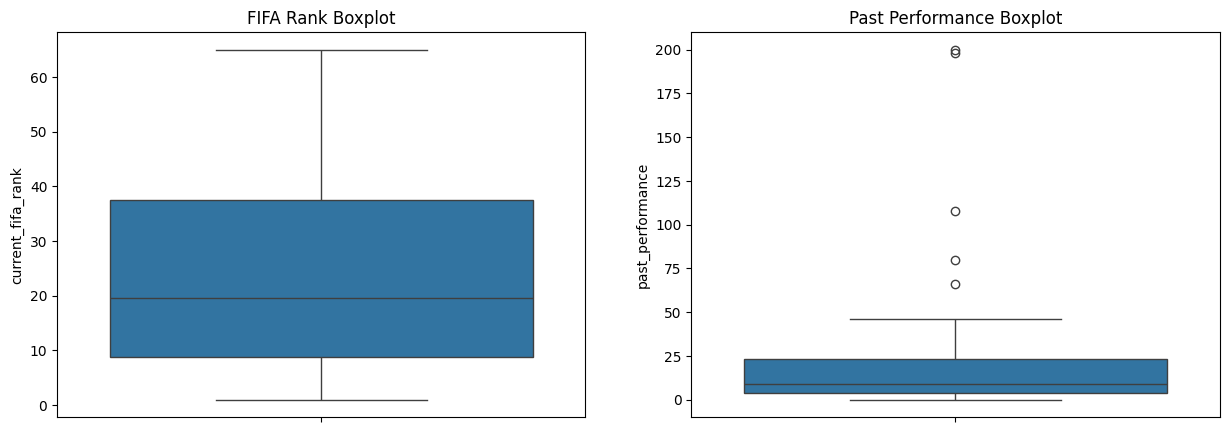

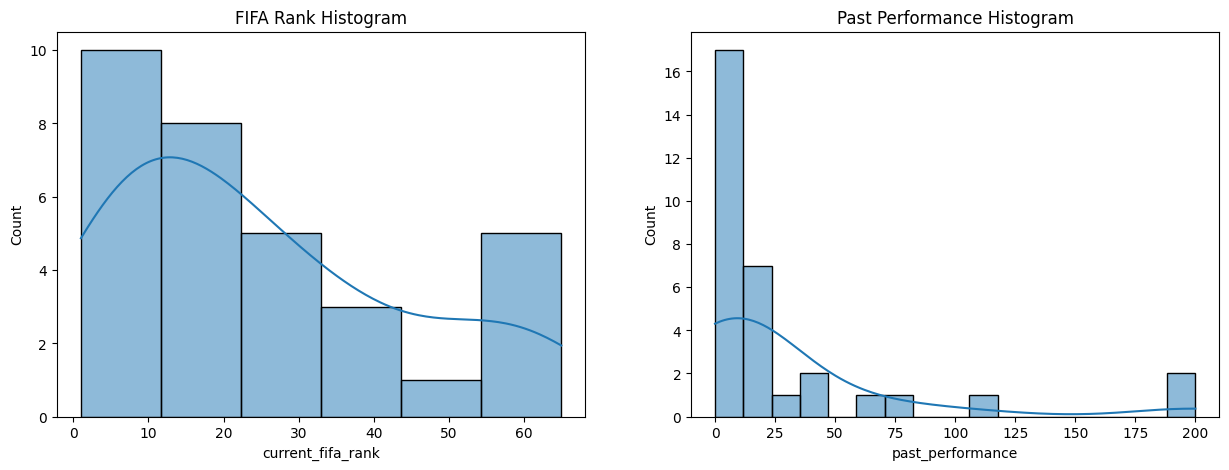

In [40]:
# Check for outliers
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.boxplot(df['current_fifa_rank'])
plt.title('FIFA Rank Boxplot')

plt.subplot(1,2,2)
sns.boxplot(df['past_performance'])
plt.title('Past Performance Boxplot')
plt.show()

# Check for normality
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(df['current_fifa_rank'], kde=True)
plt.title('FIFA Rank Histogram')

plt.subplot(1,2,2)
sns.histplot(df['past_performance'], kde=True)
plt.title('Past Performance Histogram')
plt.show()

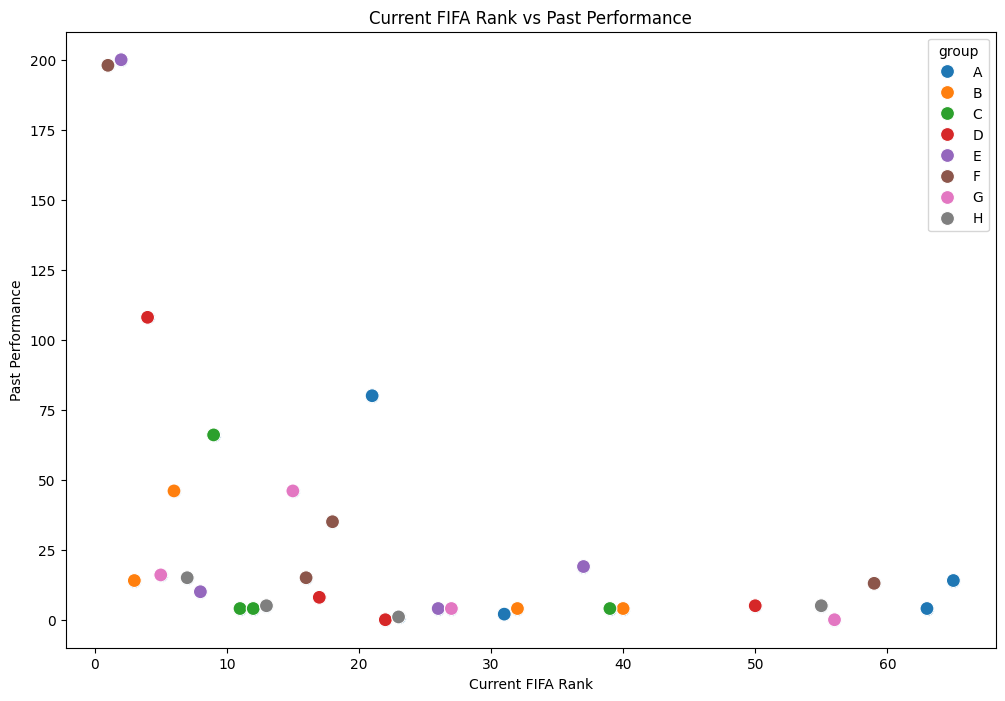

In [31]:
df.groupby('group').agg(
	team_count=('team','count'),
	mean_current_fifa_rank=('current_fifa_rank','mean'),
	mean_past_performance=('past_performance','mean')
).sort_values('mean_current_fifa_rank')

# Create a scatter plot of the data
plt.figure(figsize=(12,8))
sns.scatterplot(x='current_fifa_rank', y='past_performance', data=df, s=100)
plt.xlabel('Current FIFA Rank')
plt.ylabel('Past Performance')
plt.title('Current FIFA Rank vs Past Performance')
sns.scatterplot(x='current_fifa_rank', y='past_performance', data=df, hue='group', s=100)
plt.show()

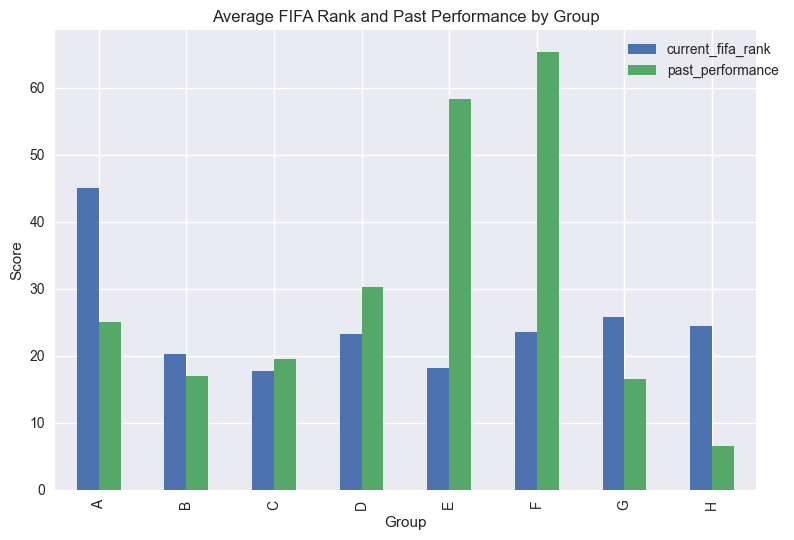

In [68]:
# 4. Group means comparison
group_means = df.groupby('group')[['current_fifa_rank', 'past_performance']].mean()
group_means.plot(kind='bar')
plt.title('Average FIFA Rank and Past Performance by Group')
plt.xlabel('Group')
plt.ylabel('Score')
plt.legend(bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

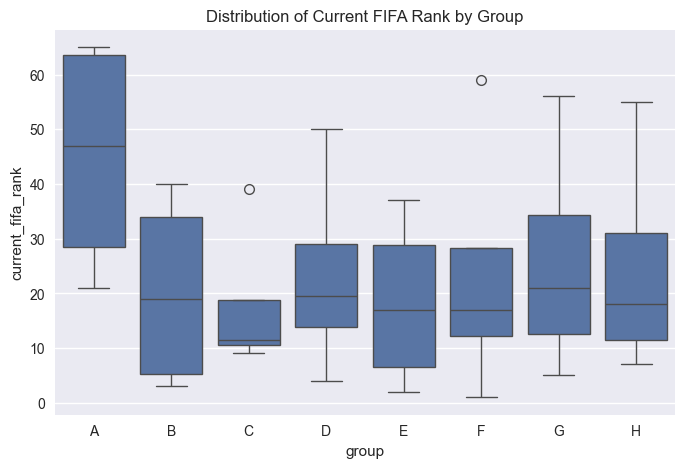

In [69]:
# Boxplot of current_fifa_rank grouped by group
plt.figure(figsize=(8,5))
sns.boxplot(x='group', y='current_fifa_rank', data=df)
plt.title("Distribution of Current FIFA Rank by Group")
plt.show()

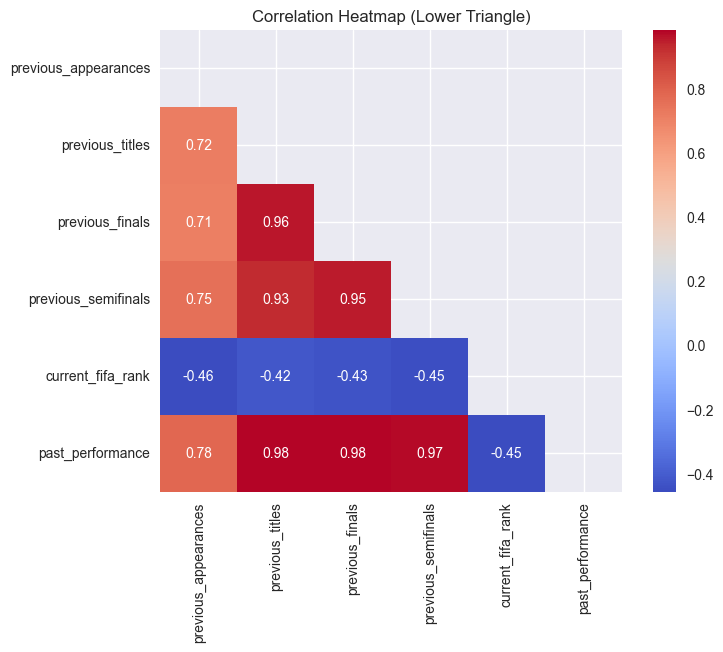

In [70]:
# Correlation heatmap of numeric columns (lower triangle only)
plt.figure(figsize=(8,6))
corr_matrix = df.select_dtypes(include=[int, float]).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Draw the heatmap with the mask
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', square=True)
plt.title("Correlation Heatmap (Lower Triangle)")
plt.show()

In [45]:
N = np.unique(df['group'].values).size
print("num comparisons: ",((N-1)*N) / 2.0)

num comparisons:  28.0


### 4. Hypothesis Testing

In [71]:
# Perform one-way ANOVA test for FIFA rankings across groups
fifa_rank_anova = stats.f_oneway(*[group['current_fifa_rank'].values 
                                  for name, group in df.groupby('group')])

# Perform one-way ANOVA test for past performance across groups
past_perf_anova = stats.f_oneway(*[group['past_performance'].values 
                                  for name, group in df.groupby('group')])

print("ANOVA Results:")
print("FIFA Rankings - F-statistic:", fifa_rank_anova.statistic, "p-value:", fifa_rank_anova.pvalue)
print("Past Performance - F-statistic:", past_perf_anova.statistic, "p-value:", past_perf_anova.pvalue)

ANOVA Results:
FIFA Rankings - F-statistic: 0.7423188075836972 p-value: 0.6390161653805875
Past Performance - F-statistic: 0.6175055399426864 p-value: 0.7361845375264922


In [72]:
# Perform pairwise t-tests for all group combinations
groups = sorted(df['group'].unique())
num_groups = len(groups)
pairwise_tests = []

for i in range(num_groups):
    for j in range(i+1, num_groups):
        group1 = df[df['group'] == groups[i]]['current_fifa_rank']
        group2 = df[df['group'] == groups[j]]['current_fifa_rank']
        t_stat, p_val = stats.ttest_ind(group1, group2)
        pairwise_tests.append({
            'group1': groups[i],
            'group2': groups[j],
            'statistic': t_stat,
            'p_value': p_val
        })

# Convert pairwise tests to DataFrame
pairwise_df = pd.DataFrame(pairwise_tests)

In [74]:
pairwise_df.head()

,group1,group2,statistic,p_value
0,A,B,1.706305,0.138826
1,A,C,2.058559,0.085226
2,A,D,1.471199,0.191647
3,A,E,1.942034,0.100159
4,A,F,1.286979,0.245519


Applying multiple comparison corrections

In [75]:
# Extract p-values from pairwise tests
p_values = pairwise_df['p_value'].values

In [76]:
# Apply Bonferroni correction
from statsmodels.stats.multitest import multipletests

# Bonferroni correction
bonferroni_results = multipletests(p_values, alpha=0.05, method='bonferroni')

From the below evaluation FALSE means no significance. 

In [89]:
# FDR correction (Benjamini-Hochberg)
fdr_results = multipletests(p_values, alpha=0.05, method='fdr_bh')

# Add corrected p-values to the pairwise comparisons DataFrame
pairwise_df['bonferroni_corrected'] = bonferroni_results[1]
pairwise_df['fdr_corrected'] = fdr_results[1]
pairwise_df['significant_bonferroni'] = bonferroni_results[0]
pairwise_df['significant_fdr'] = fdr_results[0]

# Display results
print("\nPairwise Comparisons with Multiple Testing Corrections:")
print(pairwise_df.head().round(4))


Pairwise Comparisons with Multiple Testing Corrections:
  group1 group2  statistic  p_value  bonferroni_corrected  fdr_corrected  \
0      A      B     1.7063   0.1388                   1.0         0.9879   
1      A      C     2.0586   0.0852                   1.0         0.9879   
2      A      D     1.4712   0.1916                   1.0         0.9879   
3      A      E     1.9420   0.1002                   1.0         0.9879   
4      A      F     1.2870   0.2455                   1.0         0.9879   

   significant_bonferroni  significant_fdr  
0                   False            False  
1                   False            False  
2                   False            False  
3                   False            False  
4                   False            False  


The above is truncated but it's confirmed below with an empty df there are no values in the index. 

In [83]:
# Create a summary of significant findings
significant_comparisons = pairwise_df[
    (pairwise_df['significant_bonferroni']) | 
    (pairwise_df['significant_fdr'])
]

if not significant_comparisons.empty:
    significant_comparisons = significant_comparisons.sort_values(by='p_value')

print("\nSignificant Group Differences:")
print(significant_comparisons.round(4))


Significant Group Differences:
Empty DataFrame
Columns: [group1, group2, statistic, p_value, bonferroni_corrected, fdr_corrected, significant_bonferroni, significant_fdr]
Index: []


Lets now do a comprehensive analysis of the results:

In [91]:
# Create a results summary
print("Summary of Fairness Analysis:")
print("-" * 50)

# Overall ANOVA results interpretation
if fifa_rank_anova.pvalue < 0.05:
    print("\n1. The FIFA rankings show significant differences between groups (p < 0.05)")
else:
    print("\n1. The FIFA rankings do not show significant differences between groups (p >= 0.05)")

if past_perf_anova.pvalue < 0.05:
    print("2. The past performance metrics show significant differences between groups (p < 0.05)")
else:
    print("2. The past performance metrics do not show significant differences between groups (p >= 0.05)")
    
    # Count of significant differences
print(f"\n3. Number of significant group differences:")
print(f"   - Using Bonferroni correction: {pairwise_df['significant_bonferroni'].sum()}")
print(f"   - Using FDR correction: {pairwise_df['significant_fdr'].sum()}")

# Group strength analysis
group_strength = df.groupby('group').agg({
    'current_fifa_rank': 'mean',
    'past_performance': 'mean'
}).round(2)

print("\n4. Group Strength Rankings:")
print(group_strength.sort_values('current_fifa_rank'))

Summary of Fairness Analysis:
--------------------------------------------------

1. The FIFA rankings do not show significant differences between groups (p >= 0.05)
2. The past performance metrics do not show significant differences between groups (p >= 0.05)

3. Number of significant group differences:
   - Using Bonferroni correction: 0
   - Using FDR correction: 0

4. Group Strength Rankings:
       current_fifa_rank  past_performance
group                                     
C                  17.75             19.50
E                  18.25             58.25
B                  20.25             17.00
D                  23.25             30.25
F                  23.50             65.25
H                  24.50              6.50
G                  25.75             16.50
A                  45.00             25.00


Overall, both hypothesis show no significant differences between groups. However, the FIFA rankings show a trend where Group A has the lowest average rank, while Group G has the highest. The past performance metric shows a similar trend, with Group A having the lowest average score and Group G having the highest. This suggests that Group G may be the strongest group based on both metrics.

---
**Author:** William Ruffu  
**Date:** Jan 2025 
**License:** All Rights Reserved | Open Source License | Freely distributable  
© 2025 William Ruffu